In [120]:
# predict incidence of kidney disease using medical data and linear regression

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, balanced_accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# load data
ckd_data = pd.read_csv('ckd synth 100k.csv')
ckd_data.head()

,bp (Diastolic),bp limit,sg,al,class,rbc,su,pc,pcc,ba,...,htn,dm,cad,appet,pe,ane,grf,stage,affected,age
0,1,0,≥ 1.023,< 0,ckd,0,< 0,1,0,0,...,0,0,0,0,0,0,76.949 - 102.115,s2,1,51 - 59
1,1,2,1.019 - 1.021,< 0,ckd,0,< 0,0,0,1,...,1,1,1,0,0,1,< 26.6175,s3,1,43 - 51
2,1,2,1.015 - 1.017,1 - 1,ckd,0,2 - 2,1,1,0,...,1,1,1,0,0,1,< 26.6175,s5,1,51 - 59
3,1,0,≥ 1.023,< 0,notckd,0,< 0,0,0,0,...,0,0,0,0,0,0,26.6175 - 51.7832,s3,1,12 - 20
4,1,1,≥ 1.023,< 0,notckd,0,< 0,0,0,0,...,0,0,0,0,0,0,152.446 - 177.612,s3,1,43 - 51


In [121]:
# check for missing values
ckd_data.isnull().sum()

bp (Diastolic)    0
bp limit          0
sg                0
al                0
class             0
rbc               0
su                0
pc                0
pcc               0
ba                0
bgr               0
bu                0
sod               0
sc                0
pot               0
hemo              0
pcv               0
rbcc              0
wbcc              0
htn               0
dm                0
cad               0
appet             0
pe                0
ane               0
grf               0
stage             0
affected          0
age               0
dtype: int64

In [122]:
# remove stage as it is a subset of classification
ckd_data.drop('stage', axis=1, inplace=True)

In [123]:
# check for duplicate values
ckd_data.duplicated().sum()


1507

In [124]:
# remove duplicate values
ckd_data.drop_duplicates(inplace=True)
ckd_data.duplicated().sum()

0

In [125]:
# correctly identify the column data types
ckd_data.dtypes

bp (Diastolic)     int64
bp limit           int64
sg                object
al                object
class             object
rbc                int64
su                object
pc                 int64
pcc                int64
ba                 int64
bgr               object
bu                object
sod               object
sc                object
pot               object
hemo              object
pcv               object
rbcc              object
wbcc              object
htn                int64
dm                 int64
cad                int64
appet              int64
pe                 int64
ane                int64
grf               object
affected           int64
age               object
dtype: object

In [126]:
ckd_data.head()

,bp (Diastolic),bp limit,sg,al,class,rbc,su,pc,pcc,ba,...,wbcc,htn,dm,cad,appet,pe,ane,grf,affected,age
0,1,0,≥ 1.023,< 0,ckd,0,< 0,1,0,0,...,9740 - 12120,0,0,0,0,0,0,76.949 - 102.115,1,51 - 59
1,1,2,1.019 - 1.021,< 0,ckd,0,< 0,0,0,1,...,7360 - 9740,1,1,1,0,0,1,< 26.6175,1,43 - 51
2,1,2,1.015 - 1.017,1 - 1,ckd,0,2 - 2,1,1,0,...,< 4980,1,1,1,0,0,1,< 26.6175,1,51 - 59
3,1,0,≥ 1.023,< 0,notckd,0,< 0,0,0,0,...,4980 - 7360,0,0,0,0,0,0,26.6175 - 51.7832,1,12 - 20
4,1,1,≥ 1.023,< 0,notckd,0,< 0,0,0,0,...,9740 - 12120,0,0,0,0,0,0,152.446 - 177.612,1,43 - 51


In [127]:
# count of number of affected patients
ckd_data['affected'].value_counts()

1    71035
0    27458
Name: affected, dtype: int64

In [128]:
# check for categorical variables
to_dummy = ckd_data.select_dtypes(include=['object']).columns
to_dummy

Index(['sg', 'al', 'class', 'su', 'bgr', 'bu', 'sod', 'sc', 'pot', 'hemo',
       'pcv', 'rbcc', 'wbcc', 'grf', 'age'],
      dtype='object')

In [129]:
# create dummy variables for categorical variables
ckd_dummied = pd.get_dummies(ckd_data, columns=to_dummy, drop_first=True)

In [130]:
# count variables
ckd_dummied.shape

(98493, 113)

In [131]:
def ModelReport(y_test, y_pred):
    # model results
    print("Accuracy: ", accuracy_score(y_test, y_pred))
    print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
    print("Classification Report: \n", classification_report(y_test, y_pred))
    print("ROC AUC Score: ", roc_auc_score(y_test, y_pred))

    # ROC curve to evaluate model fit
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

Accuracy:  0.8895375399766485
Confusion Matrix: 
 [[ 4388  1033]
 [ 1143 13135]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.79      0.81      0.80      5421
           1       0.93      0.92      0.92     14278

    accuracy                           0.89     19699
   macro avg       0.86      0.86      0.86     19699
weighted avg       0.89      0.89      0.89     19699

ROC AUC Score:  0.8646957615736367


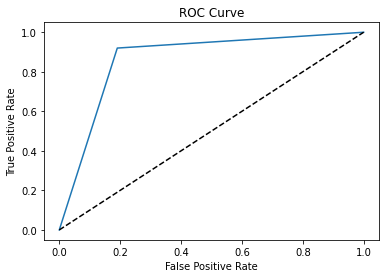

In [132]:
# As the outcome variable is binary, we can use logistic regression

# testing and training data
X = ckd_dummied.drop(['affected'], axis=1)
y = ckd_dummied['affected']

# split data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=20144717)

# preprocess data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# fit logistic regression model
logreg = LogisticRegression(random_state=20144717)
logreg.fit(X_train_scaled, y_train)

# predict outcome on test data
y_pred = logreg.predict(X_test_scaled)
y_pred

ModelReport(y_test, y_pred)

In [133]:
# count of number of affected and unaffected patients in the training data
y_train.value_counts()

1    56757
0    22037
Name: affected, dtype: int64

In [134]:
# employ recursive feature elimination to reduce the number of features

logreg = LogisticRegression(random_state=20144717)
rfe = RFE(logreg, step = 50)
rfe = rfe.fit(X_train_scaled, y_train)

# check which features are selected
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('bp (Diastolic)', False, 3),
 ('bp limit', True, 1),
 ('rbc', True, 1),
 ('pc', True, 1),
 ('pcc', True, 1),
 ('ba', True, 1),
 ('htn', True, 1),
 ('dm', True, 1),
 ('cad', True, 1),
 ('appet', True, 1),
 ('pe', True, 1),
 ('ane', True, 1),
 ('sg_1.015 - 1.017', False, 2),
 ('sg_1.019 - 1.021', True, 1),
 ('sg_< 1.007', False, 3),
 ('sg_≥ 1.023', True, 1),
 ('al_2 - 2', False, 3),
 ('al_3 - 3', True, 1),
 ('al_< 0', True, 1),
 ('al_≥ 4', False, 2),
 ('class_notckd', True, 1),
 ('su_2 - 2', True, 1),
 ('su_3 - 4', False, 2),
 ('su_4 - 4', True, 1),
 ('su_< 0', True, 1),
 ('su_≥ 4', True, 1),
 ('bgr_154 - 196', True, 1),
 ('bgr_196 - 238', True, 1),
 ('bgr_238 - 280', True, 1),
 ('bgr_280 - 322', True, 1),
 ('bgr_322 - 364', False, 3),
 ('bgr_364 - 406', False, 3),
 ('bgr_406 - 448', False, 3),
 ('bgr_< 112', False, 3),
 ('bgr_≥ 448', False, 3),
 ('bu_162.4 - 200.5', False, 3),
 ('bu_200.5 - 238.6', False, 3),
 ('bu_238.6 - 276.7', False, 3),
 ('bu_48.1 - 86.2', False, 3),
 ('bu_86.2 -

In [135]:
# build model with selected features
rfe_var = X_train.columns[rfe.support_]

X_train_red = X_train[rfe_var]
X_test_red = X_test[rfe_var]

rfe_lr = LogisticRegression(random_state=20144717)
rfe_lr.fit(X_train_red, y_train)

# model summary
print("Intercept :", rfe_lr.intercept_)

# predict outcome on test data
y_pred_rfe = rfe_lr.predict(X_test_red)
print("Accuracy :", accuracy_score(y_test, y_pred_rfe))

Intercept : [3.36917121]
Accuracy : 0.889283719985786


#### As there are a large number of dimensions once dummies are created, an alternative approach will be explored

In [136]:
ckd_labelled = ckd_data.copy()

# Encode labels to the categorical variables

le = LabelEncoder()
to_label = ckd_labelled.select_dtypes(include=['object']).columns
for col in to_label:
    ckd_labelled[col] = le.fit_transform(ckd_labelled[col])

Accuracy:  0.8828426395939086
Confusion Matrix: 
 [[2160  534]
 [ 620 6536]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.78      0.80      0.79      2694
           1       0.92      0.91      0.92      7156

    accuracy                           0.88      9850
   macro avg       0.85      0.86      0.85      9850
weighted avg       0.88      0.88      0.88      9850

ROC AUC Score:  0.8575705779317059


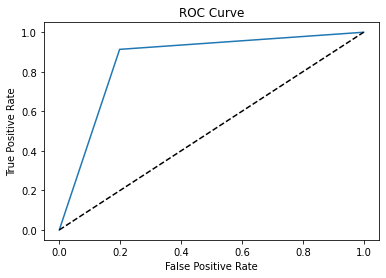

In [137]:
# testing and training data
X = ckd_labelled.drop(['affected'], axis=1)
y = ckd_labelled['affected']

# split data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=20144717)

# preprocess data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# fit logistic regression model
logreg = LogisticRegression(random_state=20144717)
logreg.fit(X_train_scaled, y_train)

# predict outcome on test data
y_pred = logreg.predict(X_test_scaled)
y_pred

ModelReport(y_test, y_pred)

In [138]:
# use paramerter tuning to find the best parameters for the model
# not all of these parameters are universally compatible, this will return a number of errors
param_grid = {'C': [0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2', 'elasticnet'], 'solver': ['liblinear', 'saga', 'lbfgs']}
grid_search = GridSearchCV(LogisticRegression(random_state=20144717), param_grid, cv=10)
grid_search.fit(X_train_scaled, y_train)

# check the best parameters
print("Best parameters :", grid_search.best_params_)
best_param = grid_search.best_params_

# check the best score
print("Best score :", grid_search.best_score_)

c:\Users\ciano\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ciano\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ciano\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\ciano\AppData\Local\Programs\Py

Best parameters : {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best score : 0.8864884455663675


Accuracy:  0.882741116751269
Confusion Matrix: 
 [[2160  534]
 [ 621 6535]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.78      0.80      0.79      2694
           1       0.92      0.91      0.92      7156

    accuracy                           0.88      9850
   macro avg       0.85      0.86      0.85      9850
weighted avg       0.88      0.88      0.88      9850

ROC AUC Score:  0.8575007064951492


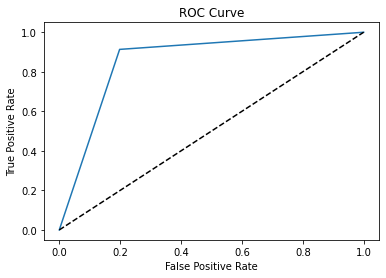

In [139]:
# use the best parameters to build the model
logreg_best = LogisticRegression(C=best_param['C'], penalty=best_param['penalty'], solver=best_param['solver'], random_state=20144717)
logreg_best.fit(X_train_scaled, y_train)

# predict outcome on test data
y_pred = logreg_best.predict(X_test_scaled)
y_pred

ModelReport(y_test, y_pred)

#### We seem to have reached the limit of what is possible through logistic regression, and will explore 

Accuracy:  0.8831472081218275
Confusion Matrix: 
 [[2068  626]
 [ 525 6631]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.80      0.77      0.78      2694
           1       0.91      0.93      0.92      7156

    accuracy                           0.88      9850
   macro avg       0.86      0.85      0.85      9850
weighted avg       0.88      0.88      0.88      9850

ROC AUC Score:  0.8471333829643581


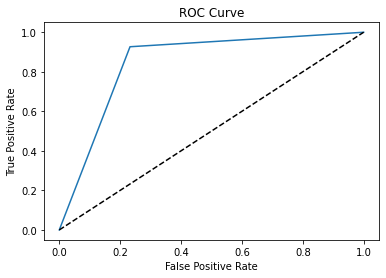

In [140]:
# apply a random forest classifier to the data
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=20144717)
rf.fit(X_train_scaled, y_train)

# predict outcome on test data
y_pred = rf.predict(X_test_scaled)
y_pred

ModelReport(y_test, y_pred)

In [141]:
# tune the parameters for the random forest classifier using random search
param_dist = {'n_estimators': randint(low=10, high=200),
                'max_depth': randint(low=1, high=10),
                'min_samples_split': randint(low=2, high=10),
                'min_samples_leaf': randint(low=1, high=10),
                'max_features': randint(low=1, high=28),
                'bootstrap': [True, False]}

random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=10, cv=3, scoring='f1_weighted', random_state=20144717)
random_search.fit(X_train_scaled, y_train)
best_p = random_search.best_params_
print(random_search.best_params_)
print(random_search.best_score_)

{'bootstrap': False, 'max_depth': 7, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 152}
0.8867913983818742


Accuracy:  0.8848730964467005
Confusion Matrix: 
 [[2098  596]
 [ 538 6618]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.80      0.78      0.79      2694
           1       0.92      0.92      0.92      7156

    accuracy                           0.88      9850
   macro avg       0.86      0.85      0.85      9850
weighted avg       0.88      0.88      0.88      9850

ROC AUC Score:  0.8517929830196329


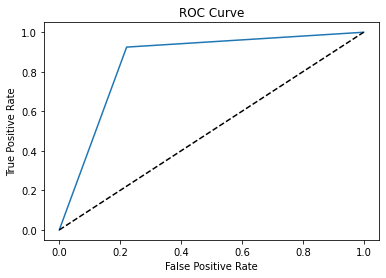

In [142]:
# use the best parameters to build the rf model
rf_best = RandomForestClassifier(n_estimators=best_p['n_estimators'], max_depth=best_p['max_depth'], 
                                min_samples_split=best_p['min_samples_split'], min_samples_leaf=best_p['min_samples_leaf'], 
                                max_features=best_p['max_features'], bootstrap=best_p['bootstrap'], random_state=20144717)
rf_best.fit(X_train_scaled, y_train)

# predict outcome on test data
y_pred = rf_best.predict(X_test_scaled)
y_pred

ModelReport(y_test, y_pred)

Accuracy:  0.8526903553299492
Confusion Matrix: 
 [[2056  638]
 [ 813 6343]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.72      0.76      0.74      2694
           1       0.91      0.89      0.90      7156

    accuracy                           0.85      9850
   macro avg       0.81      0.82      0.82      9850
weighted avg       0.86      0.85      0.85      9850

ROC AUC Score:  0.8247832377438136


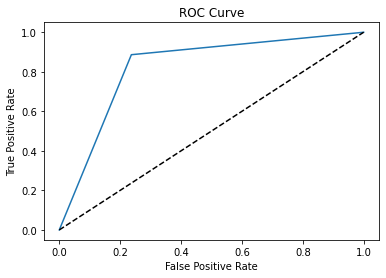

In [143]:
# apply neural network to the data

mlp = MLPClassifier(hidden_layer_sizes=(150, 100, 50), max_iter=800, solver='adam', activation='logistic', random_state=20144717)
mlp.fit(X_train_scaled, y_train)

# predict outcome on test data
y_pred = mlp.predict(X_test_scaled)
y_pred

# check accuracy of model
accuracy_score(y_test, y_pred)

ModelReport(y_test, y_pred)

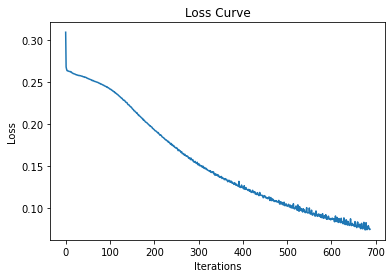

In [144]:
# plot loss curve
plt.plot(mlp.loss_curve_)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()

Accuracy:  0.8662944162436548
Confusion Matrix: 
 [[2118  576]
 [ 741 6415]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.74      0.79      0.76      2694
           1       0.92      0.90      0.91      7156

    accuracy                           0.87      9850
   macro avg       0.83      0.84      0.83      9850
weighted avg       0.87      0.87      0.87      9850

ROC AUC Score:  0.8413210338856237


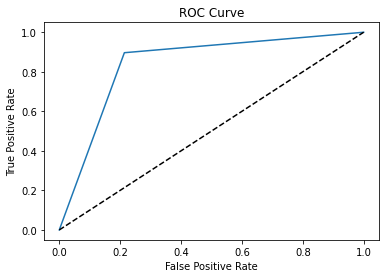

In [145]:
# apply neural network to the data with different layer approach

mlp = MLPClassifier(hidden_layer_sizes=(200,), max_iter=800, solver='adam', activation='logistic', random_state=20144717)
mlp.fit(X_train_scaled, y_train)

# predict outcome on test data
y_pred = mlp.predict(X_test_scaled)
y_pred

ModelReport(y_test, y_pred)

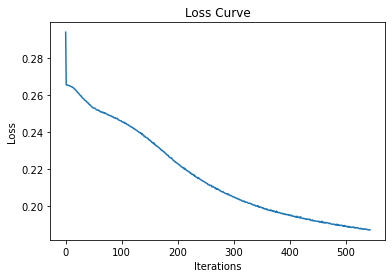

In [146]:
# plot loss curve
plt.plot(mlp.loss_curve_)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()

Accuracy:  0.8744162436548223
Confusion Matrix: 
 [[2166  528]
 [ 709 6447]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.75      0.80      0.78      2694
           1       0.92      0.90      0.91      7156

    accuracy                           0.87      9850
   macro avg       0.84      0.85      0.85      9850
weighted avg       0.88      0.87      0.88      9850

ROC AUC Score:  0.8524656058242589


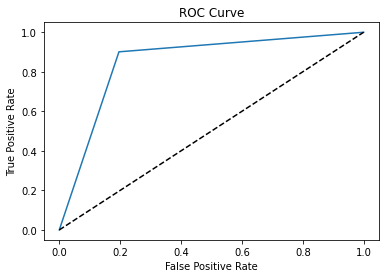

In [147]:
# apply neural network to the data with different activation function

mlp = MLPClassifier(hidden_layer_sizes=(200,), max_iter=500, solver='adam', activation='relu', random_state=20144717)
mlp.fit(X_train_scaled, y_train)

# predict outcome on test data
y_pred = mlp.predict(X_test_scaled)
y_pred

ModelReport(y_test, y_pred)

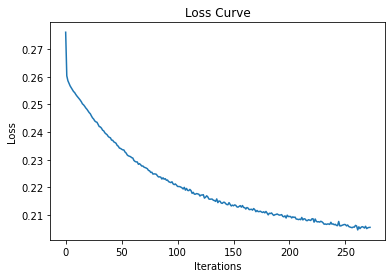

In [148]:
# plot loss curve
plt.plot(mlp.loss_curve_)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()